In [1]:
''' Copyright [2019] [Jeong, Soyeon]

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 
Unless required by applicable law or agreed to in writing,
software distributed under the License is distributed on an "AS IS" BASIS, 
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions andlimitations under the License. '''

#Author Jeong, Soyeon, kt01067774539@gmail.com 
#Supervisor Na, In Seop, ypencil@hanmail.net 
#Starting 2019.01.04
#Reference https://www.kaggle.com/ashishpatel26/think-differently-what-s-cooking

import numpy as np
import pandas as pd
import json
import re

from sklearn.multiclass import OneVsRestClassifier
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, LabelEncoder

from tqdm import tqdm
tqdm.pandas()

1. 데이터 불러오기

In [2]:
train = pd.read_json('train.json')
test = pd.read_json('test.json')

2. 데이터 분석
 1) cuisine의 종류 : 20개

In [3]:
train["cuisine"].value_counts()

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

In [4]:
train["cuisine"].value_counts()

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

 3) 각 cuisine 별로 자주 사용되는 재료 찾기

In [5]:
from collections import Counter
import operator

distinct_ingr = train['ingredients'].apply(lambda x:','.join(x))
cuisines = train['cuisine']
top=' '
total = Counter(','.join(distinct_ingr).split(','))

for cuisine in cuisines.unique():
    ingr = Counter(','.join(distinct_ingr[cuisines == cuisine]).split(','))
    ingr_score = {k:(float(ingr[k])/len(ingr))**2/(float(total[k])/len(total)) for k in ingr.keys()}
               
    top += "\n\n<"+cuisine+">\n"
    for item in sorted(ingr_score.items(), key = lambda x:x[1],reverse=True)[0:5]:
        top += " ."+item[0]
    if(cuisine=="russian"):
        print("\n"+top)


 

<greek>
 .feta cheese crumbles .feta cheese .fresh dill .cucumber .dried oregano

<southern_us>
 .buttermilk .butter .all-purpose flour .baking powder .salt

<filipino>
 .soy sauce .cooking oil .calamansi juice .lumpia wrappers .garlic

<indian>
 .garam masala .ground turmeric .cumin seed .tumeric .green chilies

<jamaican>
 .ground allspice .scotch bonnet chile .allspice .jamaican jerk season .thyme

<spanish>
 .spanish chorizo .saffron threads .sherry vinegar .extra-virgin olive oil .chorizo sausage

<italian>
 .grated parmesan cheese .olive oil .extra-virgin olive oil .salt .fresh basil

<mexican>
 .corn tortillas .avocado .salsa .flour tortillas .jalapeno chilies

<chinese>
 .soy sauce .sesame oil .corn starch .oyster sauce .hoisin sauce

<british>
 .milk .stilton cheese .golden syrup .suet .unsalted butter

<thai>
 .fish sauce .coconut milk .lemongrass .Thai red curry paste .red curry paste

<vietnamese>
 .fish sauce .beansprouts .rice vermicelli .rice paper .lemongrass

<caju

 4) 그래프로 cuisine 나타내기

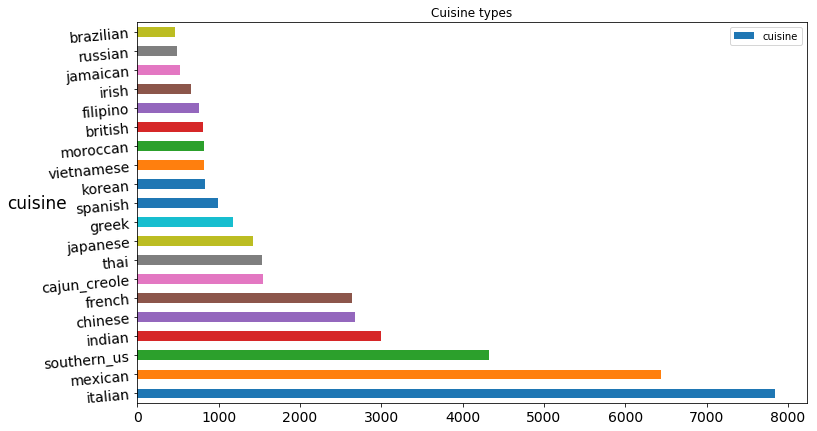

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = train['cuisine'].value_counts().plot(kind='barh', title ="Cuisine types", figsize=(12, 7), legend=True, fontsize=14, rot=5)
ax.set_ylabel("cuisine", fontsize=17, rotation=0)
plt.show()

 5) 사용되는 재료의 수 음식 별로 파악하기

In [8]:
train['num_ingredients'] = train['ingredients'].apply(lambda x: len(x))
test['num_ingredients'] = test['ingredients'].apply(lambda x: len(x))
train.sort_values(by=["num_ingredients"],ascending=True).head(20)

,cuisine,id,ingredients,num_ingredients
30636,spanish,32772,[sweetened condensed milk],1
13178,thai,29570,[grained],1
23512,french,35028,[haricots verts],1
22119,french,41135,[butter],1
18136,thai,39186,[jasmine rice],1
34531,greek,10816,[phyllo],1
10506,mexican,32631,[corn tortillas],1
21008,italian,39221,[cherry tomatoes],1
8990,indian,41124,[butter],1
8181,japanese,16116,[udon],1


 6) 2가지 이하의 재료만 사용되는 음식 제외시키기

In [9]:
train = train[train['num_ingredients'] > 2]

In [10]:
train.sort_values(by=["num_ingredients"],ascending=True).head(20)

,cuisine,id,ingredients,num_ingredients
5857,japanese,251,"[sugar, mayonaise, garlic chili sauce]",3
36682,southern_us,6395,"[coconut syrup, half & half, diet dr. pepper]",3
34008,southern_us,36348,"[baby back ribs, spices, sauce]",3
23494,japanese,21333,"[brown rice, white rice, soy sauce]",3
34019,mexican,41619,"[processed cheese, chili powder, chili]",3
37977,irish,1687,"[cream, cr챔me de menthe, brandy]",3
9082,italian,21603,"[basil, roma tomatoes, fresh mozzarella]",3
36686,indian,26330,"[urad dal, seeds, rice]",3
6243,british,6371,"[sour cream, heavy cream, confectioners sugar]",3
19712,japanese,49116,"[dried bonito flakes, konbu, water]",3


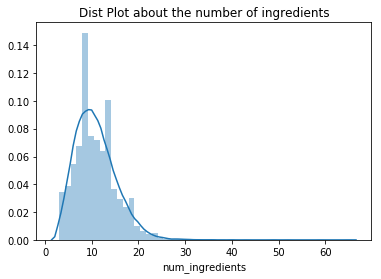

In [11]:
sns.distplot(train["num_ingredients"])
plt.title("Dist Plot about the number of ingredients")
plt.show()

 7) 재료 이름 변경 후 단어로 만들기

In [12]:
lemmatizer = WordNetLemmatizer()
def preprocess(ingredients):
    ingredients_text = ' '.join(ingredients)
    ingredients_text = ingredients_text.lower()
    
    ingredients_text = ingredients_text.replace('-', '')
    ingredients_text = ingredients_text.replace('wasabe', 'wasabi')
    ingredients_text = ingredients_text.replace('fish sauce', 'fishsauce')
    ingredients_text = ingredients_text.replace('coconut cream', 'coconutcream')
    ingredients_text = ingredients_text.replace('yellow onion', 'yellowonion')
    ingredients_text = ingredients_text.replace('cream cheese', 'creamcheese') 
    ingredients_text = ingredients_text.replace('baby spinach', 'babyspinach')
    ingredients_text = ingredients_text.replace('coriander seeds', 'corianderseeds')
    ingredients_text = ingredients_text.replace('corn tortillas', 'corntortillas')
    ingredients_text = ingredients_text.replace('rice cakes', 'ricecakes')
    
    words = []
    for word in ingredients_text.split():
        if re.findall('[0-9]', word): continue
        if len(word) <= 2: continue
        if '’' in word: continue
        word = lemmatizer.lemmatize(word)
        if len(word) > 0: words.append(word)
    return ' '.join(words)

In [13]:
train['new_ingredients'] = train['ingredients'].progress_apply(lambda ingredients: preprocess(ingredients))
test['new_ingredients'] = test['ingredients'].progress_apply(lambda ingredients: preprocess(ingredients))
train.head()

100%|████████████████████████████████████████████████████████████████████████████| 9944/9944 [00:03<00:00, 2620.02it/s]


,cuisine,id,ingredients,num_ingredients,new_ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...",9,romaine lettuce black olive grape tomato garli...
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g...",11,plain flour ground pepper salt tomato ground b...
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12,egg pepper salt mayonaise cooking oil green ch...
3,indian,22213,"[water, vegetable oil, wheat, salt]",4,water vegetable oil wheat salt
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe...",20,black pepper shallot cornflour cayenne pepper ...


 8) TfidfVectorizer

In [14]:
vectorizer = make_pipeline(
    TfidfVectorizer(sublinear_tf=True),
    FunctionTransformer(lambda x: x.astype('float'), validate=False)
)

In [15]:
x_train = vectorizer.fit_transform(train['new_ingredients'].values)
x_train.sort_indices()
x_test = vectorizer.transform(test['new_ingredients'].values)

 9) cuisine에 라벨 인코딩(0~19)

In [16]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train['cuisine'].values)
dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

{'brazilian': 0,
 'british': 1,
 'cajun_creole': 2,
 'chinese': 3,
 'filipino': 4,
 'french': 5,
 'greek': 6,
 'indian': 7,
 'irish': 8,
 'italian': 9,
 'jamaican': 10,
 'japanese': 11,
 'korean': 12,
 'mexican': 13,
 'moroccan': 14,
 'russian': 15,
 'southern_us': 16,
 'spanish': 17,
 'thai': 18,
 'vietnamese': 19}

3. 모델 만들기

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [18]:
train_data=train.drop("cuisine", axis=1)
train_data=train_data.drop("ingredients", axis=1)
train_data=train_data.drop("new_ingredients", axis=1)
target=train['cuisine']

 1)  LogisticRegression : 0.78197

In [19]:
#clf = LogisticRegression()
#parameters = {'C':[1, 10]}
#score=cross_val_score(clf, train_data, target, cv=k_fold, n_jobs=1, scoring='accuracy')
#round(np.mean(score)*100, 2)
#0.78197

 2)  KNeighborsClassifier : 0.75573

In [20]:
#classifier = KNeighborsClassifier(n_neighbors = 10)
#score=cross_val_score(classifier, train_data, target, cv=k_fold, n_jobs=1, scoring='accuracy')
#round(np.mean(score)*100, 2)
#0.75573

 3)  DecisionTreeClassifier : 0.63143

In [21]:
#classifier = DecisionTreeClassifier()
#score=cross_val_score(classifier, train_data, target, cv=k_fold, n_jobs=1, scoring='accuracy')
#round(np.mean(score)*100, 2)
#0.63143

 4)  RandomForestClassifier : 0.70444

In [22]:
#classifier = RandomForestClassifier()
#score=cross_val_score(classifier, train_data, target, cv=k_fold, n_jobs=1, scoring='accuracy')
#round(np.mean(score)*100, 2)
#0.70444

 5)  OneVsRestClassifier : 0.82713
 가장 성능 뛰어난 OneVsRestClassifier 선택

In [23]:
estimator = SVC(C=300, kernel='rbf', degree=3, gamma=1.4, coef0=1, shrinking=True, tol=0.001,probability=False, cache_size=1000, 
                class_weight=None, verbose=False, max_iter=-1, decision_function_shape=None, random_state=None)

In [24]:
classifier = OneVsRestClassifier(estimator, n_jobs=-1)

4. 모델 훈련시키기

In [25]:
classifier.fit(x_train, y_train)

OneVsRestClassifier(estimator=SVC(C=300, cache_size=1000, class_weight=None, coef0=1,
  decision_function_shape=None, degree=3, gamma=1.4, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=-1)

5. test 데이터 예측

In [26]:
y_pred = label_encoder.inverse_transform(classifier.predict(x_test))

In [27]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_pred, y_pred))

[[ 103    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [   0  177    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [   0    0  376    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [   0    0    0  704    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [   0    0    0    0  167    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [   0    0    0    0    0  698    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [   0    0    0    0    0    0  280    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [   0    0    0    0    0    0    0  801    0    0    0    0    0    0
     0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0  123    0    0    0    0    0
     0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0 2057    

In [28]:
print(classification_report(y_pred, y_pred))

              precision    recall  f1-score   support

   brazilian       1.00      1.00      1.00       103
     british       1.00      1.00      1.00       177
cajun_creole       1.00      1.00      1.00       376
     chinese       1.00      1.00      1.00       704
    filipino       1.00      1.00      1.00       167
      french       1.00      1.00      1.00       698
       greek       1.00      1.00      1.00       280
      indian       1.00      1.00      1.00       801
       irish       1.00      1.00      1.00       123
     italian       1.00      1.00      1.00      2057
    jamaican       1.00      1.00      1.00       105
    japanese       1.00      1.00      1.00       305
      korean       1.00      1.00      1.00       182
     mexican       1.00      1.00      1.00      1639
    moroccan       1.00      1.00      1.00       182
     russian       1.00      1.00      1.00        98
 southern_us       1.00      1.00      1.00      1161
     spanish       1.00    

6. 제출용 csv 파일 생성

In [29]:
test['cuisine'] = y_pred
test[['id', 'cuisine']].to_csv('Jsy_submission.csv', index=False)
test[['id', 'cuisine']].head()

,id,cuisine
0,18009,irish
1,28583,southern_us
2,41580,italian
3,29752,cajun_creole
4,35687,italian
